In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array 

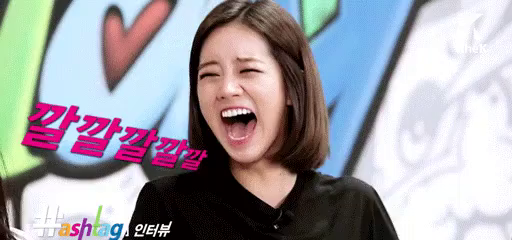

In [ ]:
model_builder = keras.applications.xception.Xception
img_size = (299,299) #원본 (250,250)이거할때는 299만되는듯?
preprocess_input=keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name="block14_sepconv2_act"
classifier_layer_names=[
    "avg_pool",
    "predictions",
]
#이미지가 있는 로컬 경로
img_path = keras.utils.get_file(
    "sample1.jpg","https://media.tenor.com/images/1e79ba7e6c3e74d48f566689ed939f4e/tenor.png" #png로해야되는듯 jpg경로는 안됐음 
) 
display(Image(img_path))

In [ ]:
def get_img_array(img_path,size):
    #PIL 이미지 크기 299*299
    img = keras.preprocessing.image.load_img(img_path,target_size=size)
    #
    array=keras.preprocessing.image.img_to_array(img)
    #
    array=np.expand_dims(array,axis=0)
    return array

In [ ]:
def make_gradcam_heatmap(
    img_array,model,last_conv_layer_name,classifier_layer_names
):
    #
    last_conv_layer=model.get_layer(last_conv_layer_name)
    last_conv_layer_model=keras.Model(model.inputs,last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    #layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name) (x)
    classifier_model = keras.Model (classifier_input, x)
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer

    with tf.GradientTape() as tape:
        last_conv_layer_output=last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)

        preds=classifier_model(last_conv_layer_output)
        top_pred_index=tf.argmax(preds[0])
        top_class_channel=preds[:,top_pred_index]

    grads=tape.gradient(top_class_channel,last_conv_layer_output)

    pooled_grads=tf.reduce_mean(grads,axis=(0,1,2))

    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads=pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:,:,i]*=pooled_grads[i]

    heatmap=np.mean(last_conv_layer_output,axis=-1)

    heatmap=np.maximum(heatmap,0)/np.max(heatmap)
    return heatmap

35363/35363 [==============================] - 0s 0us/step
Predicted [('n03595614', 'jersey', 0.33258027)]


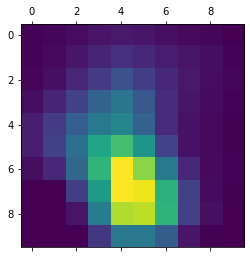

In [ ]:
#prepare image
img_array=preprocess_input(get_img_array(img_path,size=img_size))

#make model
model=model_builder(weights='imagenet')

#print what th top predicted class is
preds=model.predict(img_array)
print("Predicted",decode_predictions(preds,top=1)[0])

#Generate class activation heatmap
heatmap=make_gradcam_heatmap(
    img_array,model,last_conv_layer_name,classifier_layer_names
)

#Display heatmap
plt.matshow(heatmap)
plt.show()



# ValueError: Input 0 of layer "xception" is incompatible with the layer: expected shape=(None, 299, 299, 3), found shape=(None, 250, 250, 3)

#Create a superimposed visualization

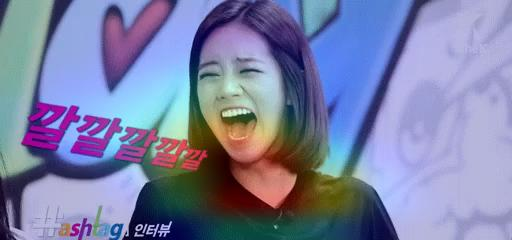

In [ ]:
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

#0~255범위로 리스케일링
heatmap = np.uint8(255 * heatmap)

#jet colormap 사용
jet=cm.get_cmap("jet")

#RGB값
jet_colors= jet(np.arange(256))[:,:3]
jet_heatmap = jet_colors[heatmap] #대괄호를 써서 불러줘야함

#RGB컬러라이징 된 히트맵 이미지 만들기 
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1],img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

#오리지널 이미지를 히트맵에 포개기
superimposed_img = jet_heatmap * 0.4 +img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

#포개진 이미지 저장하기
save_path = "sample.jpg"
superimposed_img.save(save_path)

#디스플레이에 Grad CAM 보여주기
display(Image(save_path))